IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import torch
import string
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.functional import to_map_style_dataset, sentencepiece_tokenizer
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.corpus import wordnet, stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
from gensim.models import Word2Vec
from nltk.corpus import sentiwordnet as swn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')

c:\MySoftware\Anaconda\envs\FYP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [4]:
# Utilizing GPU for faster training
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

LOADING DATASET

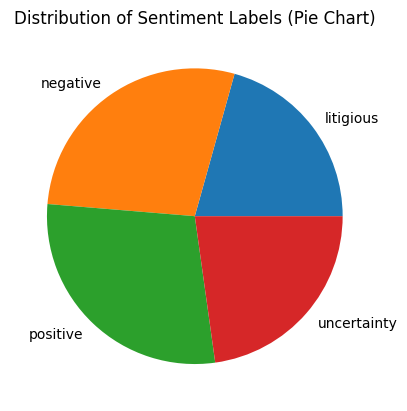

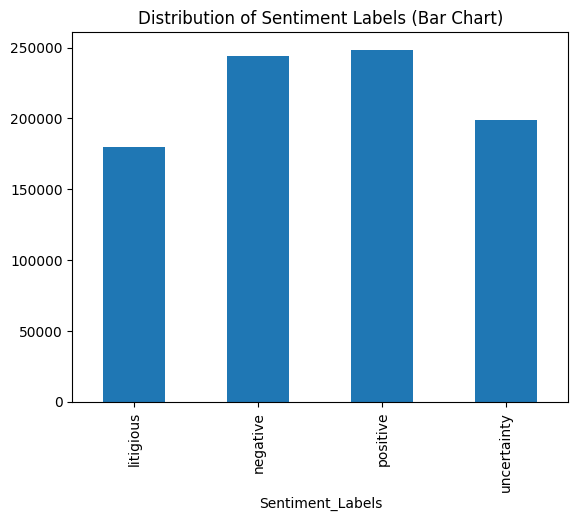

In [5]:
# Filter only English tweets
# Convert all columns to string type
# Drop all rows with any NaN and NaT values
UnC_Data = pd.read_csv('./Sentiment_Dataset/Text/4/dataset.csv', low_memory=False).query('Language == "en"').astype(str).dropna()

# Only keep the text and label columns
UnC_Data = UnC_Data[['Text', 'Label']]

# Rename the "Label" column as "sentiment labels"
UnC_Data = UnC_Data.rename(columns={'Label': 'Sentiment_Labels'})

# Visualize the distribution of the labels - Pie Chart
UnC_Data.groupby(['Sentiment_Labels']).size().plot.pie()
plt.title('Distribution of Sentiment Labels (Pie Chart)')
plt.show()

# Visualize the distribution of the labels - Bar Chart
UnC_Data.groupby(['Sentiment_Labels']).size().plot.bar()
plt.title('Distribution of Sentiment Labels (Bar Chart)')
plt.show()


DATA PREPROCESSING

In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Pre-compiling regular expressions
emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"
                          u"\U0001F300-\U0001F5FF"
                          u"\U0001F680-\U0001F6FF"
                          u"\U0001F1E0-\U0001F1FF"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

def clean_and_preprocess(tweet):
    if not isinstance(tweet, str):
        return ""

    # Combine regular expressions
    temp = re.sub(r'http\S+|@\S+|#|\[.*?\]|[()!?]', ' ', tweet.lower())
    temp = re.sub("[^a-z0-9\s]", " ", temp)

    # Tokenization and Lemmatization (NLTK library) using list comprehension
    words = [lemmatizer.lemmatize(word) for word in re.findall(r'\b\w+\b', temp) if word not in stop_words]

    # Join the list of words back into a sentence
    processed_sentence = " ".join(words)

    return processed_sentence

# Apply the clean_and_preprocess function to the "Text" column
C_Data = UnC_Data.copy()
C_Data['Text'] = C_Data['Text'].apply(clean_and_preprocess)



In [7]:
C_Data.head(10)

,Text,Sentiment_Labels
0,testimony evidence court law state federal mus...,litigious
2,flagstar bank discloses data breach impacted 1...,litigious
3,rwanda set host headquarters united nation dev...,positive
4,oops typed name incorrectly today brave witnes...,litigious
5,suck since focused nature aspect thing environ...,negative
7,also relate art lot people dismayed starting a...,uncertainty
8,social security constant political crisis dist...,negative
9,broken rib puncture lung lead collapsed lung m...,negative
10,agree flawed response small many pl people pre...,negative
11,question rhetorical know russia propping marke...,negative


In [8]:
# Map the labels to numerical values
label_mapping = {'positive': 0, 'negative': 1, 'uncertainty': 2, 'litigious': 3}

# Add a new column "Numerical_Labels" to the dataset
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping)

# Alternatively, if you want to keep both columns, you can use the following:
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping).astype('int')

# Display the updated dataset
print(C_Data)

                                                     Text Sentiment_Labels  \
0       testimony evidence court law state federal mus...        litigious   
2       flagstar bank discloses data breach impacted 1...        litigious   
3       rwanda set host headquarters united nation dev...         positive   
4       oops typed name incorrectly today brave witnes...        litigious   
5       suck since focused nature aspect thing environ...         negative   
...                                                   ...              ...   
937849                                          dark good         positive   
937850  8 ssr amp disha salian case solved amp drug ca...         negative   
937851  accident damage raleigh fire department 2503 f...         negative   
937852                                   happy incredible         positive   
937853                                         lost found         negative   

        Numerical_Labels  
0                      3  
2        

In [9]:
pd.set_option('display.max_colwidth', 1000)  # Set the maximum column width to a larger value
C_Data.head(5)  # Visualize the first 10 rows of the dataframe

,Text,Sentiment_Labels,Numerical_Labels
0,testimony evidence court law state federal must stand cross examination,litigious,3
2,flagstar bank discloses data breach impacted 1 5 million individual cybersecurity,litigious,3
3,rwanda set host headquarters united nation development programme undp new innovation financing facility find sovereigngroup sovereignafrica undp rwanda,positive,0
4,oops typed name incorrectly today brave witness cassidyhutchinson 6 premeditatedviolence 7 probaby witnesstamperig forget markmeadows requesting pardon trumpknew trumpcapitolcoupattack capitolcoupattempt neverforgetjanuary6th neverforgetjan6th,litigious,3
5,suck since focused nature aspect thing environmental problem root social economic amp political issue simply recycling using renewable energy like fixing top floor building unsteady foundation,negative,1


In [7]:
# Save the preprocessed dataset to a CSV file for easier access
C_Data.to_csv('./Sentiment_Dataset/Text/4/C_Data5.csv', index=False)

In [10]:
# Adding the labels to a list to map ID to label and label to ID 
labels = C_Data['Sentiment_Labels'].unique().tolist()
labels = [s.strip() for s in labels ]

label_count = len(labels)

# Update label IDs to start from 1
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

# Print the ID to label and label to ID mappings
print(id2label)
print(label2id)



{0: 'litigious', 1: 'positive', 2: 'negative', 3: 'uncertainty'}
{'litigious': 0, 'positive': 1, 'negative': 2, 'uncertainty': 3}


DATASET SPLITTING

In [12]:
# labels = C_Data['Numerical_Labels']

# Split the dataset into train, test, and validation sets (8:1:1)
train_data, test_data = train_test_split(C_Data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Save the train, test, and validation datasets to CSV files
train_data.to_csv("./Sentiment_Dataset/final_split_datasets/train_data.csv", index=False)
test_data.to_csv("./Sentiment_Dataset/final_split_datasets/test_data.csv", index=False)
val_data.to_csv("./Sentiment_Dataset/final_split_datasets/val_data.csv", index=False)

# Splitting the train, test, and validation datasets into text and label columns
SIZE= C_Data.shape[0]

train_texts = list(train_data['Text'])
val_texts = list(val_data['Text'])
test_texts = list(test_data['Text'])

# Extracting label columns
train_labels = list(train_data['Numerical_Labels'])
val_labels = list(val_data['Numerical_Labels'])
test_labels = list(test_data['Numerical_Labels'])

# Check the count of each dataset
print("Train data count:", train_data.shape[0])
print("Test data count:", test_data.shape[0])
print("Validation data count:", val_data.shape[0])

Train data count: 697048
Test data count: 87131
Validation data count: 87131


In [26]:
print(train_texts[5])

say point think life life 8 month 29 day exactly point cut dry lot nuance everyone pretend case


In [13]:
# Visualize a few samples from test_texts and corresponding test_labels
print("\nSample Test Data:")
for text, label in zip(test_texts[:5], test_labels[:5]):
    print(f"Text: {text}\nLabel: {label}\n")

# Check the count of unique labels in the test set
unique_labels_test = set(test_labels)
print("Unique Labels in Test Data:", unique_labels_test)



Sample Test Data:
Text: guessing author piece actually read dobbs decision fact one opposes dobbs offered single argument legal reasoning correct mad make one legally correct
Label: 3

Text: gonna la week think probably go
Label: 2

Text: hooker save mcguire shot criminal mcguire reply owe one hooker hooker reply remember saying thing 17 year ago reference star trek episode apple 1967 spock save kirk life
Label: 3

Text: returning stream thursday lie bad anxiety streaming week due heavy workload want come back make people happy laugh lt 3
Label: 1

Text: accident nishat srinagar road 2 person died onspot detail awaited
Label: 1

Unique Labels in Test Data: {0, 1, 2, 3}


In [11]:
# Setting DistilBERT tokenizer as 'tokenizer'
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", max_length=128)

# Set model to DistilBERTForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", max_length=128, num_labels=label_count, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')


In [15]:
# class DataLoader(torch.utils.data.Dataset):
#     """
#     Custom Dataset class for handling tokenized text data and corresponding labels.
#     Inherits from torch.utils.data.Dataset.
#     """
#     def __init__(self, encodings, labels):
#         """
#         Initializes the DataLoader class with encodings and labels.

#         Args:
#             encodings (dict): A dictionary containing tokenized input text data
#                               (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
#             labels (list): A list of integer labels for the input text data.
#         """
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         """
#         Returns a dictionary containing tokenized data and the corresponding label for a given index.

#         Args:
#             idx (int): The index of the data item to retrieve.

#         Returns:
#             item (dict): A dictionary containing the tokenized data and the corresponding label.
#         """
#         # Retrieve tokenized data for the given index
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         # Add the label for the given index to the item dictionary
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         """
#         Returns the number of data items in the dataset.

#         Returns:
#             (int): The number of data items in the dataset.
#         """
#         return len(self.labels)

In [16]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

Training with trainer class

In [17]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [29]:
training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=1e-5,
    evaluation_strategy='epoch'
)

In [30]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_data,         
    eval_dataset=val_data,            
    compute_metrics= compute_metrics
)

In [33]:
trainer.train()

[nltk_data] Downloading package wordnet to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  0%|          | 0/522786 [01:02<?, ?it/s]


KeyError: 663910